In [201]:
import pandas as pd
from datetime import datetime
import math
from dateutil.relativedelta import relativedelta
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

In [202]:
data = pd.read_csv("data.csv")

In [203]:
data["Name"].tolist()

['CAN 1.5 May 22',
 'CAN 0.25 Nov 22',
 'CAN 0.25 May 23',
 'CAN 0.5 Nov 23',
 'CAN 2.25 March 24',
 'CAN 1.5 Sept 24',
 'CAN 1.25 Mar 25',
 'CAN 0.5 Sept 25',
 'CAN 0.25 Mar 26',
 'CAN 1.00 Sept 26',
 'CAN 1.25 Mar 27']

In [204]:
def get_dirty_price(clean_price, coupon_rate, maturity_date, current_date):
    last_coupon_date = maturity_date
    while last_coupon_date > date:
        last_coupon_date -= relativedelta(months=6)
    dirty_price = clean_price + (date - last_coupon_date).days / 365 * coupon_rate * 100
    return dirty_price

In [205]:
def get_present_value(coupon_rate, maturity_date, current_date, ytm):
    last_coupon_date = maturity_date
    period = 0
    while last_coupon_date > date:
        last_coupon_date -= relativedelta(months=6)
        period += 1
    coupon = coupon_rate * 100 / 2
    cash_flow = []
    for i in range(1, period+1):
        cash_flow.append(coupon * math.exp(-0.5*i*ytm))
        if i == period:
            cash_flow[-1] += 100 * math.exp(-0.5*i*ytm)
    return sum(cash_flow) * math.exp((current_date - last_coupon_date).days / 365 * ytm)

In [206]:
def get_spot_rates(clean_prices, coupon_rates, maturity_dates, current_date):
    res = []
    rates = []
    interpolated_rates = []
    for i in range(0,len(coupon_rates)):
        clean_price = clean_prices[i]
        coupon_rate = coupon_rates[i]
        coupon = coupon_rate*100/2
        maturity_date = datetime.fromisoformat(maturity_dates[i])
        
        dirty_price = get_dirty_price(clean_price, coupon_rate, maturity_date, current_date)
        if i == 0:
            # 0 <= Time to maturity <= 0.5:
            time_to_maturity = (maturity_date - current_date).days / 365
            spot_rate = -math.log(dirty_price/(coupon+100)) / time_to_maturity
            rates.append(spot_rate)
            res.append(spot_rate)
        else:
            # 0.5 < Time to maturity
            
            #Linear interpolate spot rates since some bonds with specific maturity do not exist
            if maturity_date != (datetime.fromisoformat(maturity_dates[i-1]) + relativedelta(months=6)):
                prev_rate = 0
                for rate in rates:
                    # hardcoded linear interpolation rules
                    interpolated_rates.append(prev_rate * 1/3 + rate * 2/3)
                    prev_rate = rate
                rates = interpolated_rates
                
            # boostrapping
            payments = 0
            last_coupon_date = maturity_date
            n = 0
            while last_coupon_date > date:
                last_coupon_date -= relativedelta(months=6)
                n += 1
            pre_coupon_time = [0.5 * (k+1) - (current_date - last_coupon_date).days / 365 for k in range(n)]
            # calculation present value of all previous coupon payments
            for j in range(n-1):
                payments += coupon * math.exp(-1 * rates[j] * pre_coupon_time[j])
            time_to_maturity = 0.5 * (n) - (current_date - last_coupon_date).days / 365
            spot_rate = -math.log((dirty_price - payments)/(coupon_rate*100/2+100)) / time_to_maturity
            rates.append(spot_rate)
            res.append(spot_rate)
    return res
            
        

In [208]:
all_dates = ["2022-01-10", "2022-01-11", "2022-01-12", "2022-01-13", "2022-01-14", "2022-01-17", "2022-01-18", "2022-01-19", "2022-01-20", "2022-01-21"]

In [209]:
for date_str in all_dates:
    col = []
    for index, row in data.iterrows():
        date = datetime.fromisoformat(date_str)
        clean_price = row[date_str]
        maturity_date = datetime.fromisoformat(row["Maturity date"])
        coupon_rate = row["Coupon rate"]
        dirty_price = get_dirty_price(clean_price, coupon_rate, maturity_date, date)
        get_yield = lambda ytm: get_present_value(coupon_rate, maturity_date, date, ytm) - dirty_price
        ytm = optimize.newton(get_yield, 0.05)
        col.append(ytm)
    data["ytm_"+date_str] = col
    

In [210]:
coupon_rates = data["Coupon rate"]
maturity_dates = data["Maturity date"]
for date_str in all_dates:
    current_date = datetime.fromisoformat(date_str)
    clean_prices = data[date_str]
    data["spot_"+date_str] = get_spot_rates(clean_prices, coupon_rates, maturity_dates, current_date)

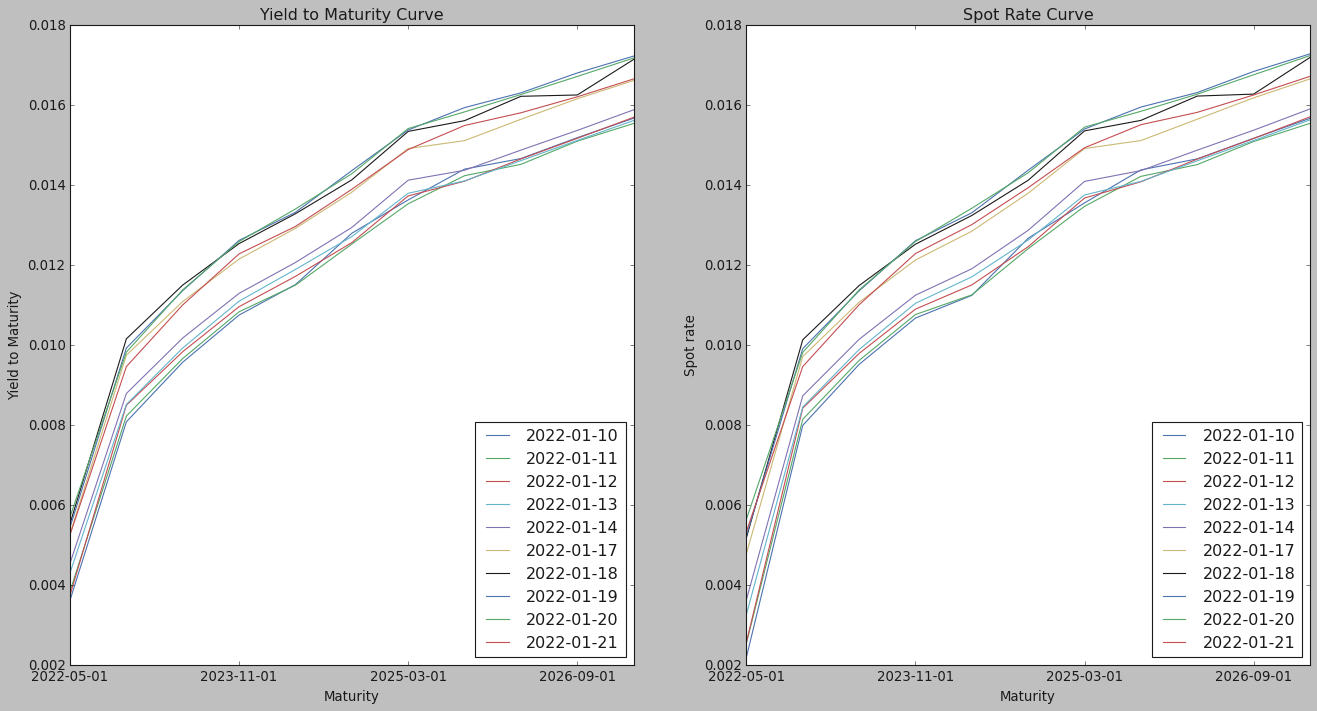

In [211]:
all_cols = ["Maturity date"] + ["ytm_" + date_str for date_str in all_dates]
plot_data=data[all_cols]
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
# plt.subplot(1, 2, figsize=(10,10)) # row 1, col 2 index 1
# plt.figure(figsize=(10, 10))
for date_str in all_dates:
    ax.plot(data['Maturity date'],plot_data['ytm_' + date_str],label=date_str)
ax.set_xticks(data['Maturity date'][::3])
ax.set_title('Yield to Maturity Curve')
ax.set_xlabel('Maturity')
ax.set_ylabel('Yield to Maturity')
ax.legend(loc='lower right')

all_cols = ["Maturity date"] + ["spot_" + date_str for date_str in all_dates]
plot_data=data[all_cols]
# plt.subplot(1, 2, figsize=(12, 10)) # index 2
# plt.figure(figsize=(12, 10))
for date_str in all_dates:
    ax2.plot(data['Maturity date'],plot_data['spot_' + date_str],label=date_str)
ax2.set_xticks(data['Maturity date'][::3])
ax2.set_title('Spot Rate Curve')
ax2.set_xlabel('Maturity')
ax2.set_ylabel('Spot rate')
ax2.legend(loc='lower right')
plt.show()

In [212]:
def get_forward_rate(spot_rates, current_date, maturity_dates):
    def interpolate_rate(target_date, prev_date, prev_rate, next_date, next_rate):
        rate = prev_rate + (target_date-prev_date).days * (next_rate - prev_rate) / (next_date - prev_date).days
        return rate
    interplated_spot_rates=[]
    target_dates=[current_date + relativedelta(months=12*i) for i in range(1, 6)]
    for i in range(5):
        rate = interpolate_rate(target_dates[i],datetime.fromisoformat(maturity_dates[2*i+1]), spot_rates[2*i+1], datetime.fromisoformat(maturity_dates[2*i+2]), spot_rates[2*i+2])
        interplated_spot_rates.append(rate)
#     print(interplated_spot_rates)
    forward_rates=[]
    for i in range(1,5):
        forward_rates.append(((i+1)*interplated_spot_rates[i]-interplated_spot_rates[0])/i)
    return forward_rates

In [214]:

all_forward_rates = []
for date_str in all_dates:
    current_date = datetime.fromisoformat(date_str)
    spot_rates = data["spot_"+date_str]
    maturity_dates = data["Maturity date"]
    rates = get_forward_rate(spot_rates, current_date, maturity_dates)
    all_forward_rates.append(rates)


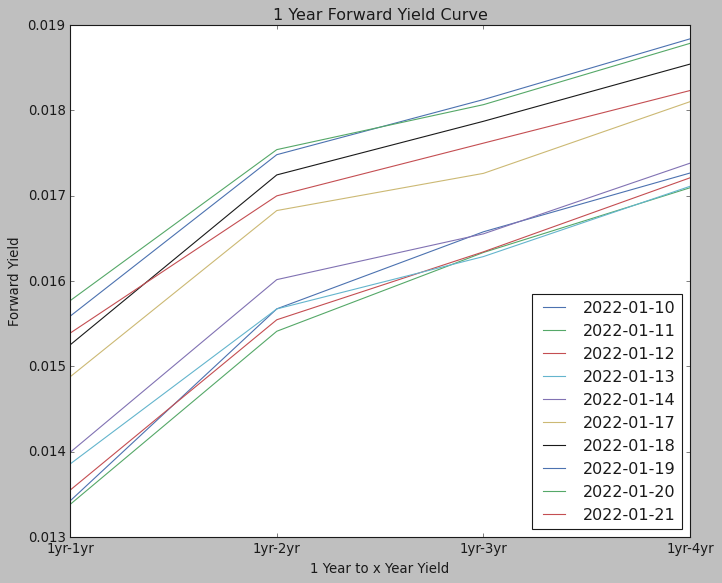

In [224]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()
for i in range(len(all_dates)):
    plt.plot(["1yr-1yr","1yr-2yr","1yr-3yr","1yr-4yr"],all_forward_rates[i],label=all_dates[i])
plt.title('1 Year Forward Yield Curve')
plt.xlabel('1 Year to x Year Yield')
plt.ylabel('Forward Yield')
ax.legend(loc='lower right')
plt.show()

In [228]:
def interpolate_rate(target_date, prev_date, prev_rate, next_date, next_rate):
    rate = prev_rate + (target_date-prev_date).days * (next_rate - prev_rate) / (next_date - prev_date).days
    return rate
new_ytm = {}
maturity_dates = data["Maturity date"]
for date_str in all_dates:
    yields = data["ytm_"+date_str]
    interpolated_yields = []
    interpolated_date = [datetime.fromisoformat(date_str) + relativedelta(months=12*i) for i in range(1, 6)]
    for i in range(5):
        target_date = interpolated_date[i]
        new_yield = interpolate_rate(target_date, datetime.fromisoformat(maturity_dates[2*i+1]), yields[2*i+1], datetime.fromisoformat(maturity_dates[2*i+2]), yields[2*i+2])
        interpolated_yields.append(new_yield)
    new_ytm[date_str] = interpolated_yields
    

In [230]:
new_ytm.keys()

dict_keys(['2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21'])

In [236]:
X=np.zeros([5,9])
for i in range(5):
    for j in range(9):
        X[i,j]=math.log(new_ytm[all_dates[j+1]][i]/new_ytm[all_dates[j]][i])
ytm_cov=np.cov(X)
ytm_cov, np.linalg.eig(ytm_cov)

(array([[0.00146271, 0.00098769, 0.00088824, 0.0007928 , 0.00074396],
        [0.00098769, 0.00072914, 0.00066711, 0.00059472, 0.0005614 ],
        [0.00088824, 0.00066711, 0.00064572, 0.00058433, 0.00055014],
        [0.0007928 , 0.00059472, 0.00058433, 0.00056217, 0.0005171 ],
        [0.00074396, 0.0005614 , 0.00055014, 0.0005171 , 0.00049123]]),
 (array([3.68259320e-03, 1.63776355e-04, 2.89223456e-05, 8.38288703e-06,
         7.29356366e-06]),
  array([[-0.61158751, -0.70711877, -0.33671241, -0.10772315, -0.03105222],
         [-0.43958765, -0.0440666 ,  0.71635947,  0.46831176,  0.26894988],
         [-0.41114743,  0.3030215 ,  0.33697172, -0.54211286, -0.57593356],
         [-0.37439556,  0.47062132, -0.46505921,  0.57638057, -0.29974807],
         [-0.35143872,  0.42980778, -0.20886321, -0.37812551,  0.71074141]])))

In [250]:
X=np.zeros([4,9])
for i in range(4):
    for j in range(9):
        X[i,j]=math.log(all_forward_rates[j+1][i]/all_forward_rates[j][i])
forward_cov=np.cov(X)
forward_cov
# np.linalg.eig(forward_cov)

array([[0.00053373, 0.00050736, 0.00044167, 0.00043049],
       [0.00050736, 0.00054753, 0.00049038, 0.000471  ],
       [0.00044167, 0.00049038, 0.000487  , 0.00044806],
       [0.00043049, 0.000471  , 0.00044806, 0.00043471]])

In [249]:
np.linalg.eig(forward_cov)

(array([1.89897837e-03, 7.81192880e-05, 1.54761078e-05, 1.03930751e-05]),
 array([[-0.50479904, -0.78187283, -0.36481497,  0.02761954],
        [-0.5316683 , -0.03708394,  0.79276201, -0.29577354],
        [-0.49165607,  0.52789954, -0.48826697, -0.49111277],
        [-0.46987344,  0.32957812,  0.0058127 ,  0.81887937]]))

In [243]:
np.array(all_forward_rates).T

array([[0.01342313, 0.01338178, 0.01354937, 0.01385553, 0.01399195,
        0.01487712, 0.01525136, 0.01558756, 0.01576936, 0.01538911],
       [0.01567359, 0.01541111, 0.01554576, 0.01567258, 0.01601615,
        0.01682561, 0.01724316, 0.01748023, 0.01753949, 0.01699777],
       [0.01657688, 0.0163344 , 0.01634174, 0.0162863 , 0.01655258,
        0.01726147, 0.01787161, 0.01812595, 0.01806649, 0.01761559],
       [0.01726561, 0.01709301, 0.01720967, 0.01711006, 0.01738115,
        0.01810187, 0.01854208, 0.01883802, 0.01878527, 0.01823227]])